# Mask R-CNN - Train on Simple Baby Dataset

Modification of the Shapes Training sample.

# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class BabiesConfig(Config):
    """Configuration for training on the babies dataset.
    Derives from the base Config class and overrides values specific
    to the babies dataset.
    """
    # Give the configuration a recognizable name
    NAME = "babies"
    
    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    # You can also provide a callable that should have the signature
    # of model.resnet_graph. If you do so, you need to supply a callable
    # to COMPUTE_BACKBONE_SHAPE as well
    BACKBONE = "resnet50"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    USE_MINI_MASK = False

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 280

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    LEARNING_RATE = 0.005
    
config = BabiesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class BabiesDataset(utils.Dataset):
    """Generates the babies dataset.
    """

    def load_babies(self, count, validation=False):
        """Generate the requested number of images.
        count: number of images to generate.
        validation: whether this is validation set.
        """
        # Add classes
        self.add_class("babies", 1, "baby")
        
        image_dir = 'Images'
        if validation:
            image_dir = os.path.join(image_dir, 'Validation')
        else:
            image_dir = os.path.join(image_dir, 'Training')

        # Add images
        for i in range(count):
            image_path = os.path.join(image_dir, '{}.png'.format(i))
            image = skimage.io.imread(image_path)
            if image.shape[2] == 4:
                image = image[:,:,:3]
            
            self.add_image("babies", image_id=i, path=image_path,
                           height=image.shape[0], width=image.shape[1])

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        elif info["source"] == "babies":
            return info
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        image_path = info['path']
        validation_path = image_path.replace('.png', '.labels.tif')
        mask = skimage.io.imread(validation_path)
        mask = mask.reshape((mask.shape[0], mask.shape[1], 1))
        class_ids = np.array([1], np.int32)
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [5]:
# Training dataset
dataset_train = BabiesDataset()
dataset_train.load_babies(28)
dataset_train.prepare()

# Validation dataset
dataset_val = BabiesDataset()
dataset_val.load_babies(5, validation=True)
dataset_val.prepare()

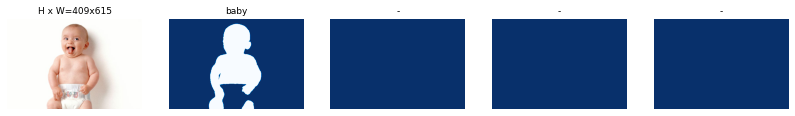

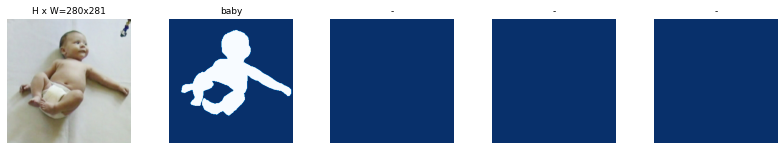

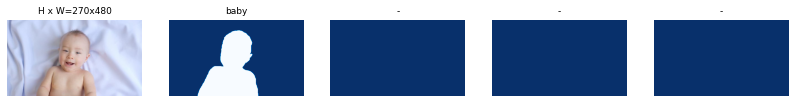

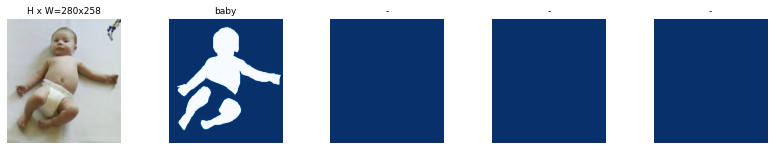

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.005

Checkpoint Path: /home/svu/e0201435/Mask_RCNN/logs/babies20210223T1710/mask_rcnn_babies_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 87/280 [========>.....................] - ETA: 1:42 - loss: 1.0886 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.3648 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.3947 - mrcnn_mask_loss: 0.2082WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.149151). Check your callbacks.


121/280 [===========>..................] - ETA: 1:21 - loss: 0.9516 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.3224 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.3238 - mrcnn_mask_loss: 0.1770WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.154336). Check your callbacks.


151/280 [===============>..............] - ETA: 1:04 - loss: 0.8687 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.3062 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.2806 - mrcnn_mask_loss: 0.1598WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.144902). Check your callbacks.


181/280 [==================>...........] - ETA: 49s - loss: 0.7874 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.2817 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 0.1467WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.149605). Check your callbacks.


214/280 [=====================>........] - ETA: 32s - loss: 0.7099 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.2568 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.2125 - mrcnn_mask_loss: 0.1356WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.152095). Check your callbacks.


243/280 [=========================>....] - ETA: 18s - loss: 0.6544 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2379 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.1911 - mrcnn_mask_loss: 0.1276WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.156193). Check your callbacks.


269/280 [===========================>..] - ETA: 5s - loss: 0.6156 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.1750 - mrcnn_mask_loss: 0.1220WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.154429). Check your callbacks.


280/280 [==============================] - 164s 586ms/step - loss: 0.5987 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.1198 - val_loss: 0.7676 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.2477 - val_mrcnn_class_loss: 0.1636 - val_mrcnn_bbox_loss: 0.1823 - val_mrcnn_mask_loss: 0.1718


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0005

Checkpoint Path: /home/svu/e0201435/Mask_RCNN/logs/babies20210223T1710/mask_rcnn_babies_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 32/280 [==>...........................] - ETA: 3:31 - loss: 0.4680 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0720WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.331418). Check your callbacks.


 58/280 [=====>........................] - ETA: 3:07 - loss: 0.4154 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0726WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.323936). Check your callbacks.


 84/280 [========>.....................] - ETA: 2:44 - loss: 0.3662 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0709WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.343680). Check your callbacks.


110/280 [==========>...................] - ETA: 2:24 - loss: 0.3299 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0206 - mrcnn_mask_loss: 0.0695WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.339245). Check your callbacks.


136/280 [=============>................] - ETA: 2:00 - loss: 0.3029 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0686WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.336552). Check your callbacks.


162/280 [================>.............] - ETA: 1:35 - loss: 0.2844 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0677WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.328544). Check your callbacks.


189/280 [===================>..........] - ETA: 1:12 - loss: 0.2670 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0668WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.326572). Check your callbacks.


215/280 [======================>.......] - ETA: 51s - loss: 0.2585 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0662WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.327963). Check your callbacks.


242/280 [========================>.....] - ETA: 30s - loss: 0.2482 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.0655WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.343358). Check your callbacks.


268/280 [===========================>..] - ETA: 9s - loss: 0.2404 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0117 - mrcnn_mask_loss: 0.0648 WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.357425). Check your callbacks.


280/280 [==============================] - 232s 827ms/step - loss: 0.2370 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0114 - mrcnn_mask_loss: 0.0646 - val_loss: 1.1797 - val_rpn_class_loss: 0.0013 - val_rpn_bbox_loss: 0.2389 - val_mrcnn_class_loss: 0.0375 - val_mrcnn_bbox_loss: 0.1501 - val_mrcnn_mask_loss: 0.1621


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(BabiesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/svu/e0201435/Mask_RCNN/logs/babies20210223T1710/mask_rcnn_babies_0002.h5
Re-starting from epoch 2


original_image           shape: (256, 256, 3)         min:    0.00000  max:  209.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  900.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   47.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


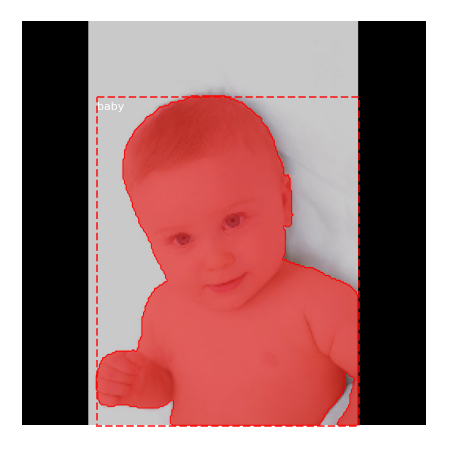

In [13]:
# Test on a training image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  209.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  105.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


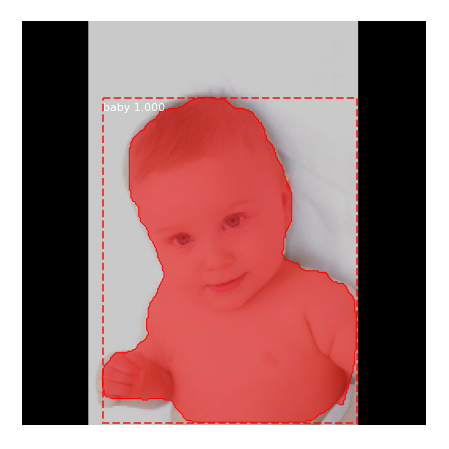

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  261.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   70.00000  max:  232.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


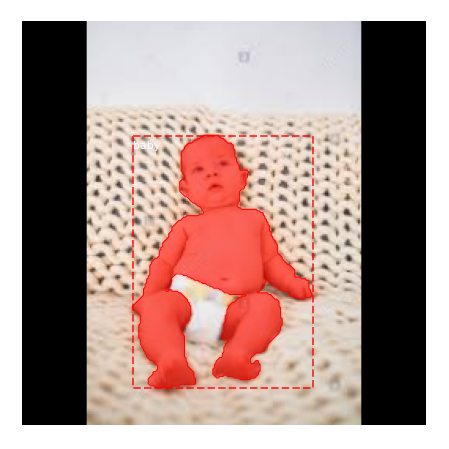

In [15]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


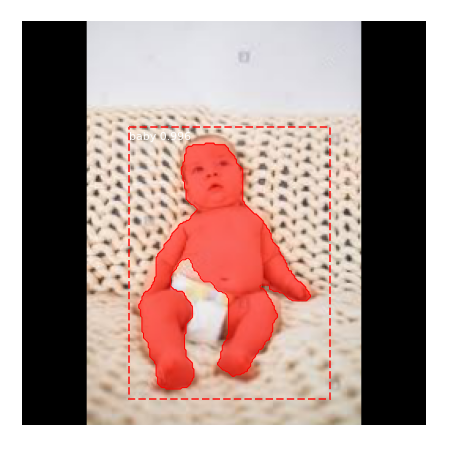

In [16]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [17]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
